# Step 1: Imports and configuaration

In [1]:
#from neuroxai.utils.config import *
#from examples import * #classification_model, segmentation_model

#from neuroxai.utils.config import *

import numpy as np
import tensorflow as tf

from neuroxai.utils.process import get_last_layer, get_last_conv_layer

from examples.classification_model import get_classification_model, load_images_2d, ResNet50V2
from examples.segmentation_model import get_deepseg, load_images
from neuroxai.utils.explain import get_neuroxai, get_neuroxai_cnn


1 Physical GPUs, 1 Logical GPUs



/home/dl_machine/anaconda3/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


# Debug

In [2]:
# NeuroXAI parameters
DIMENSION = "2d"
MODALITY = "FLAIR"
XAI_MODE = "classification"
CLASS_IDs = [0,1]
TUMOR_LABEL = "all"

# Classification model parameters
IM_SIZE=224
NETWORK=ResNet50V2 # ResNet50V2, VGG16
MODEL_WEIGHTS = "weights/ResNet50_model.hdf5"
DATASET_PATH = "/mnt/SSD/Datasets/BRATS_2019_2d/"
#DATASET_PATH = "/home/ramy/Documents/Datasets/BRATS_2019_2d/"
GRADE="HGG" #"LGG"
ID="BraTS19_TCIA02_394_1_47"
tumor_2_label = {"HGG": 0, "LGG": 1}
label_2_tumor = {0:"HGG", 1:"LGG"}

m = get_classification_model(IM_SIZE=IM_SIZE, MODEL_WEIGHTS=MODEL_WEIGHTS, NETWORK=NETWORK)
#layer_n = get_last_layer(m).name
#layer_n = get_last_conv_layer(m).name
#layer_n = "conv5_block3_3_conv"
layer_n = None

if layer_n == None:
    xai_layer = get_last_conv_layer(m)
else:
    xai_layer = m.get_layer(layer_n)

model = tf.keras.models.Model([m.inputs], [xai_layer.output, m.output])
class_id = tumor_2_label[GRADE] #np.argmax(predictions[0])

io_imgs = load_images_2d("{}/FLAIR/{}/{}.png".format(DATASET_PATH, GRADE, ID))
# show_image(im_orig)
# Predict the class
_, predictions = model(io_imgs)
prediction_class = np.argmax(predictions[0])
print("Predicted class:", prediction_class) # 0: HGG, 1: LGG
print("Confidence HGG:", float(predictions[0][0]), ", Confidence LGG:", float(predictions[0][1])) # 0: HGG, 1: LGG

Predicted class: 0
Confidence HGG: 1.0 , Confidence LGG: 1.0298291386323655e-10


Visual exaplanations for...
	 ID: BraTS19_TCIA02_394_1_47, layer: dense_1


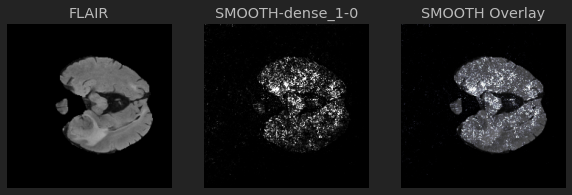

In [3]:
get_neuroxai_cnn(ID, model, io_imgs, CLASS_ID=class_id, LAYER_NAME=layer_n, XAI_MODE="classification", 
                 XAI="SMOOTH", DIMENSION="2d", CLASS_IDs=CLASS_IDs, TUMOR_LABEL=TUMOR_LABEL, SAVE_RESULTS=False, SAVE_PATH="Class_Results")

Visual exaplanations for...
	 ID: BraTS19_TCIA02_394_1_47, layer: dense_1


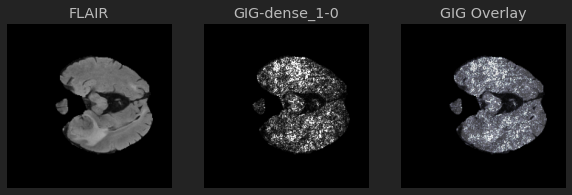

In [3]:
get_neuroxai_cnn(ID, model, io_imgs, CLASS_ID=class_id, LAYER_NAME=layer_n, XAI_MODE="classification", 
                 XAI="GIG", DIMENSION="2d", CLASS_IDs=CLASS_IDs, TUMOR_LABEL=TUMOR_LABEL, SAVE_RESULTS=False, SAVE_PATH="Class_Results")

Visual exaplanations for...
	 ID: BraTS19_TCIA02_394_1_47, layer: dense_1


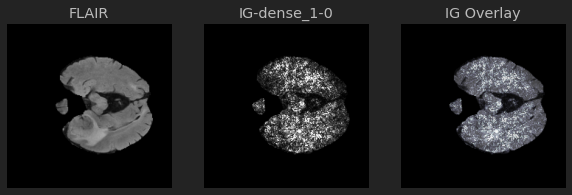

In [4]:
get_neuroxai_cnn(ID, model, io_imgs, CLASS_ID=class_id, LAYER_NAME=layer_n, XAI_MODE="classification", 
                 XAI="IG", DIMENSION="2d", CLASS_IDs=CLASS_IDs, TUMOR_LABEL=TUMOR_LABEL, SAVE_RESULTS=False, SAVE_PATH="Class_Results")

Visual exaplanations for...
	 ID: BraTS19_TCIA02_394_1_47, layer: dense_3


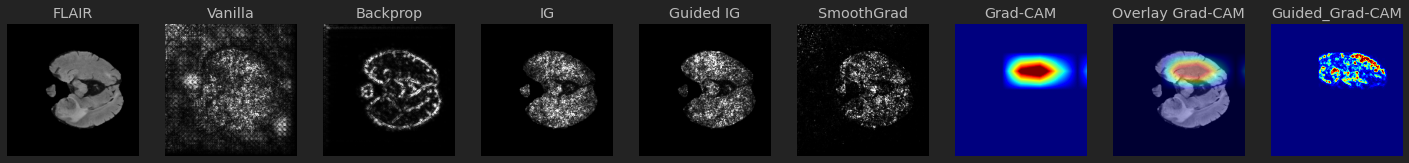

In [6]:
get_neuroxai(ID, model, io_imgs, CLASS_ID=class_id, LAYER_NAME=layer_n, XAI_MODE="classification",
             DIMENSION="2d", CLASS_IDs=CLASS_IDs, TUMOR_LABEL=TUMOR_LABEL, SAVE_RESULTS=False, SAVE_PATH="Class_Results")

# Step 3: Explainable learning (3D Grad-CAM, GuidedGrad-CAM)
https://github.com/fitushar/3D-Grad-CAM/
https://github.com/fitushar/3D-GuidedGradCAM-for-Medical-Imaging

## NeuroXAI Experiment 3: Segmentation CNN

### debugging

In [7]:
# NeuroXAI parameters
DIMENSION = "3d"
MODALITY = "FLAIR"
XAI_MODE = "segmentation"
CLASS_IDs = [1,2,3]
TUMOR_LABEL = "all" # for GCAM visualization

# Segmentation model parameters
#DATASET_PATH = './'
#DATASET_PATH = '/home/ramy/Documents/Datasets/BRATS_2021_preprocess'
DATASET_PATH = '/mnt/SSD/Datasets/BRATS_2021/BraTS2021_TrainingData/' # RT
IMG_SHAPE = (192, 224, 160)

deepseg_model = get_deepseg()
deepseg_model.load_weights("weights/DeepSeg_model.hdf5")
#deepseg_model.summary(line_length=120)

m = deepseg_model
#layer_n = 'conv3d_15'
layer_n = 'output_layer' # output_layer_soft
#layer_n = 'conv3d_22' #conv3d_10
tumor_l = "all"
conv_layer = m.get_layer(layer_n)
# conv_layer = m.get_layer('conv3d_1065')

model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])

# ID = "BraTS2021_00523" # case ID
# ID = "BraTS2021_00377" # case ID
ID = "BraTS2021_01092"
#ID = "BraTS2021_01291"
SLICE_ID = 77
CLASS_INDEX = 2 #np.argmax(predictions[0])
TUMOR_LABEL="all" # for grad-CAM

io_imgs = load_images(model, ID, PATH_DATA=DATASET_PATH, DIM=IMG_SHAPE)
im_orig = io_imgs[:,:,:,SLICE_ID,0] # 2D FLAIR

Visual exaplanations for...
	 ID: BraTS2021_01092, layer: output_layer


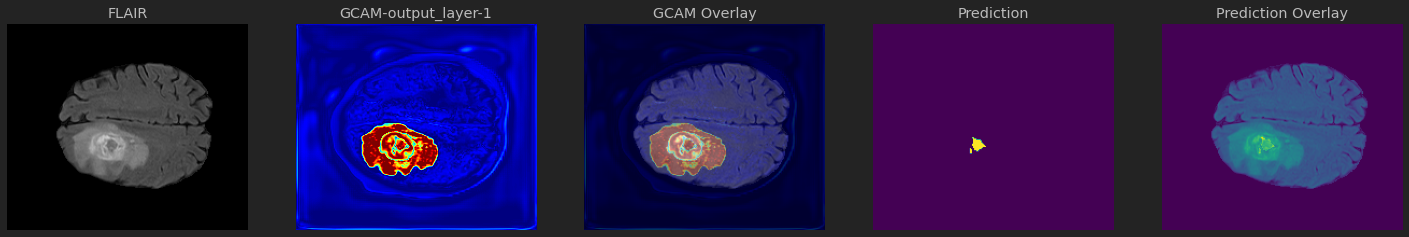

In [10]:
get_neuroxai_cnn(ID, model, io_imgs, CLASS_ID=1, SLICE_ID=101, LAYER_NAME='output_layer', MODALITY="FLAIR", 
                 XAI_MODE="segmentation", XAI="GCAM", DIMENSION="3d", CLASS_IDs=CLASS_IDs, TUMOR_LABEL=TUMOR_LABEL, 
                 SAVE_RESULTS=False, SAVE_PATH="NeuroXAI_Exp3_Seg_GGCAM")

Visual exaplanations for...
	 ID: BraTS2021_01092, layer: output_layer


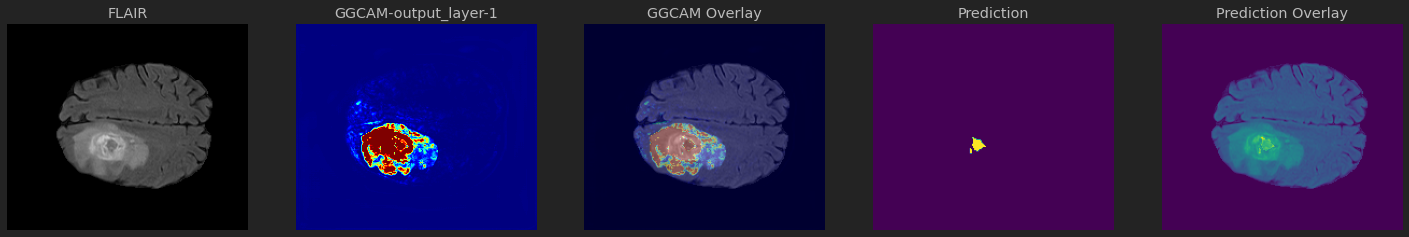

In [11]:
get_neuroxai_cnn(ID, model, io_imgs, CLASS_ID=1, SLICE_ID=101, LAYER_NAME='output_layer', MODALITY="FLAIR", 
                 XAI_MODE="segmentation", XAI="GGCAM", DIMENSION="3d", CLASS_IDs=CLASS_IDs, TUMOR_LABEL=TUMOR_LABEL, 
                 SAVE_RESULTS=False, SAVE_PATH="NeuroXAI_Exp3_Seg_GGCAM")

Visual exaplanations for...
	 ID: BraTS2021_01092, layer: output_layer_soft


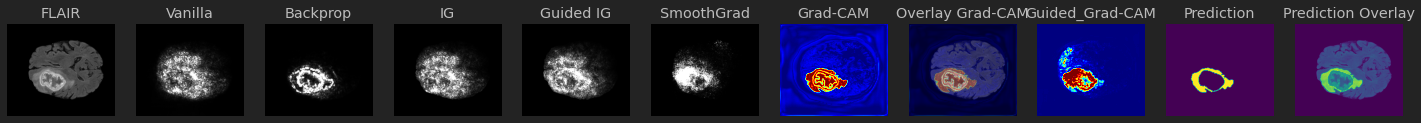

In [12]:
get_neuroxai(ID, model, io_imgs, CLASS_ID=2, SLICE_ID=77, LAYER_NAME=None, MODALITY="FLAIR", XAI_MODE="segmentation", 
                     DIMENSION="3d", CLASS_IDs=CLASS_IDs, TUMOR_LABEL=TUMOR_LABEL, SAVE_RESULTS=False, SAVE_PATH="NeuroXAI_Exp2_Seg_All")

### Exp 3

In [ ]:
# debugging
m = deepseg_model
#layer_n = 'conv3d_15'
layer_n = 'output_layer' # output_layer_soft
#layer_n = 'activation_25' #conv3d_10
tumor_l = "all"
conv_layer = m.get_layer(layer_n)
# conv_layer = m.get_layer('conv3d_1065')

model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])

# ID = "BraTS2021_00523" # case ID
# ID = "BraTS2021_00377" # case ID
ID = config["brats_input_path"] # BraTS2021_01092
SLICE_ID = 77
CLASS_INDEX = 2 #np.argmax(predictions[0])
TUMOR_LABEL="all" # for grad-CAM

imgs_preprocess, pred_data_3ch, pred_data_m, pred_data_m_post = load_images(model, ID=config["brats_input_path"], 
                                                                            post_enhancing=config["post_enhancing"])

io_imgs = imgs_preprocess[np.newaxis, ...]
im_orig = imgs_preprocess[:,:,SLICE_ID,0] # 2D FLAIR

In [ ]:
# save nifti for all layers
Good_IDs = ["BraTS2021_01652", "BraTS2021_00542", "BraTS2021_01381"]
Good_SLICE_IDs = [111, 65, 95]

modalities = {"FLAIR","T1","T1CE","T2"}
tumor_labels = {0,1,2,3}
m_id = 0
modality="FLAIR"
save_path="NeuroXAI_Exp3_CNN_GCAM/"
XAI_IDs = Good_IDs
SLICE_IDs = Good_SLICE_IDs
TUMOR_LABEL="all1" # for grad-CAM
        
for n, case_id in enumerate(XAI_IDs):
    #if n>0: break
    print("Explainaing case: {} ({}/{})".format(case_id, n+1, len(XAI_IDs)))
    for label in tumor_labels:
        #if label != "l0": break
        print("\tLabel:", label)
        for i in range(26):
            #if i!=25: continue
            print("\t\tLayer:", i+1)
            if i == 0:
                layer_name = 'conv3d'
            elif i == 25:
                layer_name = 'output_layer'
            else:
                layer_name = 'conv3d_{}'.format(i)
            
            conv_layer = m.get_layer(layer_name)
            model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])
            
            get_neuroxai_cnn(case_id, model, io_imgs, CLASS_ID=label, SLICE_ID=SLICE_IDs[n], LAYER_NAME=layer_name, MODALITY=modality, 
                               XAI_MODE="segmentation", XAI="GCAM", DIMENSION="3d", SAVE_RESULTS=True, SAVE_PATH=save_path)

In [ ]:
# save nifti for all layers
Good_IDs = ["BraTS2021_01652", "BraTS2021_00542", "BraTS2021_01381"]
Good_SLICE_IDs = [111, 65, 95]

modalities = {"FLAIR","T1","T1CE","T2"}
m_id = 0
modality="FLAIR"
save_path="NeuroXAI_Exp3_CNN_GCAM_All/"
XAI_IDs = Good_IDs
SLICE_IDs = Good_SLICE_IDs
TUMOR_LABEL="all" # for grad-CAM
        
for n, case_id in enumerate(XAI_IDs):
        #if n>0: break
        print("Explainaing case: {} ({}/{})".format(case_id, n+1, len(XAI_IDs)))
        label=2
        for i in range(26):
            #if i!=25: continue
            print("\t\tLayer:", i+1)
            if i == 0:
                layer_name = 'conv3d'
            elif i == 25:
                layer_name = 'output_layer'
            else:
                layer_name = 'conv3d_{}'.format(i)
            
            conv_layer = m.get_layer(layer_name)
            model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])
            
            get_neuroxai_cnn(case_id, model, io_imgs, CLASS_ID=label, SLICE_ID=SLICE_IDs[n], LAYER_NAME=layer_name, MODALITY=modality, 
                               XAI_MODE="segmentation", XAI="GCAM", DIMENSION="3d", SAVE_RESULTS=True, SAVE_PATH=save_path)

In [ ]:
# save nifti for all layers
Good_IDs = ["BraTS2021_01652", "BraTS2021_00542", "BraTS2021_01381"]
Good_SLICE_IDs = [111, 65, 95]

modalities = {"FLAIR","T1","T1CE","T2"}
tumor_labels = {0,1,2,3}
m_id = 0
modality="FLAIR"
save_path="NeuroXAI_Exp3_CNN_GGCAM/"
XAI_IDs = Good_IDs
SLICE_IDs = Good_SLICE_IDs
TUMOR_LABEL="all1" # for grad-CAM
        
for n, case_id in enumerate(XAI_IDs):
    #if n>0: break
    print("Explainaing case: {} ({}/{})".format(case_id, n+1, len(XAI_IDs)))
    for label in tumor_labels:
        #if label != "l0": break
        print("\tLabel:", label)
        for i in range(26):
            #if i!=25: continue
            print("\t\tLayer:", i+1)
            if i == 0:
                layer_name = 'conv3d'
            elif i == 25:
                layer_name = 'output_layer'
            else:
                layer_name = 'conv3d_{}'.format(i)
            
            conv_layer = m.get_layer(layer_name)
            model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])
            
            get_neuroxai_cnn(case_id, model, 6, CLASS_ID=label, SLICE_ID=SLICE_IDs[n], LAYER_NAME=layer_name, MODALITY=modality, 
                               XAI_MODE="segmentation", XAI="GGCAM", DIMENSION="3d", SAVE_RESULTS=True, SAVE_PATH=save_path)

In [ ]:
# save nifti for all layers
Good_IDs = ["BraTS2021_01652", "BraTS2021_00542", "BraTS2021_01381"]
Good_SLICE_IDs = [111, 65, 95]

modalities = {"FLAIR","T1","T1CE","T2"}
tumor_labels = {1,2,3}
m_id = 0
modality="FLAIR"
save_path="NeuroXAI_Exp3_CNN_GGCAM_All/"
XAI_IDs = Good_IDs
SLICE_IDs = Good_SLICE_IDs
TUMOR_LABEL="all" # for grad-CAM
        
for n, case_id in enumerate(XAI_IDs):
        #if n>0: break
        print("Explainaing case: {} ({}/{})".format(case_id, n+1, len(XAI_IDs)))
        label=2
        for i in range(26):
            #if i!=25: continue
            print("\t\tLayer:", i+1)
            if i == 0:
                layer_name = 'conv3d'
            elif i == 25:
                layer_name = 'output_layer'
            else:
                layer_name = 'conv3d_{}'.format(i)
            
            conv_layer = m.get_layer(layer_name)
            model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])
            
            get_neuroxai_cnn(case_id, model, io_imgs, CLASS_ID=label, SLICE_ID=SLICE_IDs[n], LAYER_NAME=layer_name, MODALITY=modality, 
                               XAI_MODE="segmentation", XAI="GGCAM", DIMENSION="3d", SAVE_RESULTS=True, SAVE_PATH=save_path)

In [ ]:
model.summary()

## NeuroXAI Experiment 2: Segmentation comparative study (All XAI methods)

In [ ]:
# debugging
m = deepseg_model
#layer_n = 'conv3d_15'
layer_n = 'output_layer' # output_layer_soft
#layer_n = 'activation_25' #conv3d_10
tumor_l = "all"
conv_layer = m.get_layer(layer_n)
# conv_layer = m.get_layer('conv3d_1065')

model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])

# ID = "BraTS2021_00523" # case ID
# ID = "BraTS2021_00377" # case ID
ID = config["brats_input_path"] # BraTS2021_01092
SLICE_ID = 77
CLASS_INDEX = 2 #np.argmax(predictions[0])
TUMOR_LABEL="all" # for grad-CAM

imgs_preprocess, pred_data_3ch, pred_data_m, pred_data_m_post = load_images(model, ID=config["brats_input_path"], 
                                                                            post_enhancing=config["post_enhancing"])

io_imgs = imgs_preprocess[np.newaxis, ...]
im_orig = imgs_preprocess[:,:,SLICE_ID,0] # 2D FLAIR

In [ ]:
get_neuroxai(ID, model, io_imgs, CLASS_ID=2, SLICE_ID=77, LAYER_NAME=None, MODALITY="FLAIR", XAI_MODE="segmentation", 
                     DIMENSION="3d", SAVE_RESULTS=True, SAVE_PATH="NeuroXAI_Exp2_Seg_All")

In [ ]:
get_neuroxai(ID, model, io_imgs, CLASS_ID=2, SLICE_ID=77, LAYER_NAME=layer_n, MODALITY="FLAIR", XAI_MODE="segmentation", 
                     DIMENSION="3d", SAVE_RESULTS=True, SAVE_PATH="NeuroXAI_Exp2_Seg_All")

### XAI for the last layer (last conv for GCAM)

In [ ]:
# save nifti for all layers
XAI_IDs = ["BraTS2021_01652", "BraTS2021_00542", "BraTS2021_01381"]
SLICE_IDs = [111, 65, 95]

modalities = {"FLAIR","T1","T1CE","T2"}
modality="FLAIR"
save_path="NeuroXAI_Exp2_Seg_All/"
TUMOR_LABEL="all1" # for grad-CAM
label=2

for n, case_id in enumerate(XAI_IDs):
    #if n>0: break
    print("Explainaing case: {} ({}/{})".format(case_id, n+1, len(XAI_IDs)))
    for label in tumor_labels:
        #if label != "l0": break
        print("\tLabel:", label)
        get_neuroxai(case_id, model, io_imgs, CLASS_ID=label, SLICE_ID=SLICE_IDs[n], LAYER_NAME=None, MODALITY=modality, XAI_MODE="segmentation", 
                     DIMENSION="3d", SAVE_RESULTS=True, SAVE_PATH=save_path)


In [ ]:
# save nifti for all layers
XAI_IDs = ["BraTS2021_01652", "BraTS2021_00542", "BraTS2021_01381"]
SLICE_IDs = [111, 65, 95]

modalities = {"FLAIR","T1","T1CE","T2"}
modality="FLAIR"
save_path="NeuroXAI_Exp2_Seg_All/"
TUMOR_LABEL="all" # for grad-CAM
label=2

for n, case_id in enumerate(XAI_IDs):
    #if n>0: break
    print("Explainaing case: {} ({}/{})".format(case_id, n+1, len(XAI_IDs)))
    get_neuroxai(case_id, model, io_imgs, CLASS_ID=label, SLICE_ID=SLICE_IDs[n], LAYER_NAME=None, MODALITY=modality, 
                       XAI_MODE="segmentation", DIMENSION="3d", SAVE_RESULTS=True, SAVE_PATH=save_path)

### XAI for the last conv layer

In [ ]:
# save nifti for all layers
Good_IDs = ["BraTS2021_01652", "BraTS2021_00542", "BraTS2021_01381"]
Good_SLICE_IDs = [111, 65, 95]

modalities = {"FLAIR","T1","T1CE","T2"}
tumor_labels = {0,1,2,3}
modality="FLAIR"
save_path="NeuroXAI_Exp2_Seg/"
XAI_IDs = Good_IDs
SLICE_IDs = Good_SLICE_IDs
layer_n='output_layer'
TUMOR_LABEL="all1" # for grad-CAM

for n, case_id in enumerate(XAI_IDs):
    #if n>0: break
    print("Explainaing case: {} ({}/{})".format(case_id, n+1, len(XAI_IDs)))
    for label in tumor_labels:
        #if label != "l0": break
        print("\tLabel:", label)
        get_neuroxai(case_id, model, io_imgs, CLASS_ID=label, SLICE_ID=SLICE_IDs[n], LAYER_NAME=layer_n, MODALITY=modality, XAI_MODE="segmentation", 
                     DIMENSION="3d", SAVE_RESULTS=True, SAVE_PATH=save_path)


In [ ]:
# save nifti for all layers
Good_IDs = ["BraTS2021_01652", "BraTS2021_00542", "BraTS2021_01381"]
Good_SLICE_IDs = [111, 65, 95]

modalities = {"FLAIR","T1","T1CE","T2"}
tumor_labels = {1,2,3}
m_id = 0
modality="FLAIR"
save_path="NeuroXAI_Exp2_Seg_All/"
XAI_IDs = Good_IDs
SLICE_IDs = Good_SLICE_IDs
layer_n='output_layer'
TUMOR_LABEL="all" # for grad-CAM
label=2
for n, case_id in enumerate(XAI_IDs):
    #if n>0: break
    print("Explainaing case: {} ({}/{})".format(case_id, n+1, len(XAI_IDs)))
    get_neuroxai(case_id, model, io_imgs, CLASS_ID=label, SLICE_ID=SLICE_IDs[n], LAYER_NAME=layer_n, MODALITY=modality, 
                       XAI_MODE="segmentation", DIMENSION="3d", SAVE_RESULTS=True, SAVE_PATH=save_path)
    
# XAI for the last conv layer

## NeuroXAI Experiment 1: Classification comparative study (All XAI methods)

### debugging

In [4]:
# NeuroXAI parameters
DIMENSION = "2d"
MODALITY = "FLAIR"
XAI_MODE = "classification"
CLASS_IDs = [0,1]

# Classification model parameters
IM_SIZE=224
NETWORK=ResNet50V2 # ResNet50V2, VGG16
MODEL_WEIGHTS = "weights/ResNet50_model.hdf5"
DATASET_PATH = "/mnt/SSD/Datasets/BRATS_2019_2d/"
#DATASET_PATH = "/home/ramy/Documents/Datasets/BRATS_2019_2d/"
GRADE="HGG" #"LGG"
ID="BraTS19_TCIA02_394_1_47"
tumor_2_label = {"HGG": 0, "LGG": 1}
label_2_tumor = {0:"HGG", 1:"LGG"}
TUMOR_LABEL = "all"
m = get_classification_model(IM_SIZE=IM_SIZE, MODEL_WEIGHTS=MODEL_WEIGHTS, NETWORK=NETWORK)
#layer_n = get_last_layer(m).name
#layer_n = get_last_conv_layer(m).name
#layer_n = "conv5_block3_3_conv"
layer_n = None

if layer_n == None:
    xai_layer = get_last_conv_layer(m)
else:
    xai_layer = m.get_layer(layer_n)

model = tf.keras.models.Model([m.inputs], [xai_layer.output, m.output])
class_id = tumor_2_label[GRADE] #np.argmax(predictions[0])

io_imgs = load_images_2d("{}/FLAIR/{}/{}.png".format(DATASET_PATH, GRADE, ID))
# show_image(im_orig)
# Predict the class
_, predictions = model(io_imgs)
prediction_class = np.argmax(predictions[0])
print("Predicted class:", prediction_class) # 0: HGG, 1: LGG
print("Confidence HGG:", float(predictions[0][0]), ", Confidence LGG:", float(predictions[0][1])) # 0: HGG, 1: LGG

Predicted class: 0
Confidence HGG: 1.0 , Confidence LGG: 1.0297956931637486e-10


Visual exaplanations for...
	 ID: BraTS19_TCIA02_394_1_47, layer: dense_3


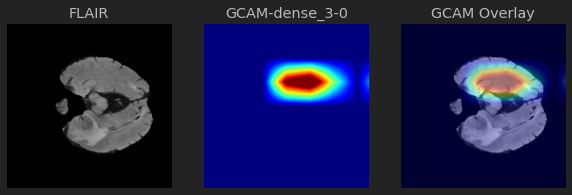

In [5]:
get_neuroxai_cnn(ID, model, io_imgs, CLASS_ID=class_id, LAYER_NAME=layer_n, XAI_MODE="classification", 
                 XAI="GCAM", DIMENSION="2d", CLASS_IDs=CLASS_IDs, TUMOR_LABEL=TUMOR_LABEL, SAVE_RESULTS=False, SAVE_PATH="Class_Results")

Visual exaplanations for...
	 ID: BraTS19_TCIA02_394_1_47, layer: dense_3


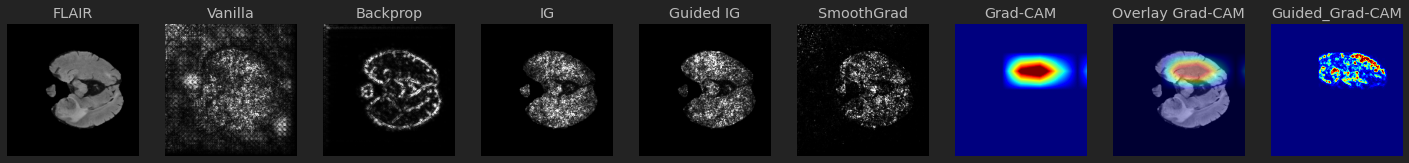

In [6]:
get_neuroxai(ID, model, io_imgs, CLASS_ID=class_id, LAYER_NAME=layer_n, XAI_MODE="classification",
             DIMENSION="2d", CLASS_IDs=CLASS_IDs, TUMOR_LABEL=TUMOR_LABEL, SAVE_RESULTS=False, SAVE_PATH="Class_Results")

### Exp 1

In [ ]:
NETWORK=ResNet50V2 # ResNet50V2, VGG16
PROJECT_NAME="ResNet50_model"
MODEL_WEIGHTS = "weights/"+PROJECT_NAME+".hdf5"
#MODEL_WEIGHTS = "weights/resnet_model-300.hdf5"

GRADE="HGG" #"LGG"
tumor_2_label = {"HGG": 0, "LGG": 1}
label_2_tumor = {0:"HGG", 1:"LGG"}
HGG_IDs = ["BraTS19_2013_3_1_84", "BraTS19_2013_2_1_87",
           "BraTS19_TCIA03_199_1_79", "BraTS19_CBICA_BAX_1_51", "BraTS19_CBICA_AOD_1_67", 
           "BraTS19_CBICA_AOO_1_83", "BraTS19_CBICA_AOZ_1_73",
           "BraTS19_TCIA01_499_1_47",  "BraTS19_TCIA02_117_1_47", "BraTS19_TCIA02_394_1_43", "BraTS19_TCIA02_394_1_47"] # small parts
LGG_IDs = ["BraTS19_2013_0_1_73", "BraTS19_2013_1_1_53", "BraTS19_2013_6_1_103", "BraTS19_2013_16_1_91",
          "BraTS19_2013_24_1_81", "BraTS19_2013_28_1_73", "BraTS19_2013_29_1_99", "BraTS19_TCIA09_141_1_111",
          "BraTS19_TCIA09_254_1_43", "BraTS19_TCIA09_255_1_81", "BraTS19_TCIA09_402_1_77", "BraTS19_TCIA10_109_1_93",
          "BraTS19_TCIA10_152_1_47", "BraTS19_TCIA10_351_1_81"]
# Done 1, 2, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16
# ID=LGG_IDs[10]
ID="BraTS19_TCIA02_394_1_47"
DIMENSION="2d"
CLASS_IDs = [0,1]

m = get_classification_model(MODEL_WEIGHTS=MODEL_WEIGHTS, NETWORK=NETWORK)
#layer_n = get_last_layer(m).name
#layer_n = get_last_conv_layer(m).name
#layer_n = "conv5_block3_3_conv"
layer_n = None

if layer_n == None:
    xai_layer = get_last_conv_layer(m)
else:
    xai_layer = m.get_layer(layer_n)

model = tf.keras.models.Model([m.inputs], [xai_layer.output, m.output])
class_id = tumor_2_label[GRADE] #np.argmax(predictions[0])


#im_orig = cv2.imread(DATASET_PATH+"FLAIR/LGG/BraTS19_2013_1_1_58.png")
#im_orig = cv2.imread("{}/FLAIR/{}/{}.png".format(DATASET_PATH, GRADE, ID))
io_imgs = load_images_2d("{}/FLAIR/{}/{}.png".format(DATASET_PATH, GRADE, ID))
# show_image(im_orig)
# Predict the class
_, predictions = model(io_imgs)
prediction_class = np.argmax(predictions[0])
print("Predicted class:", prediction_class) # 0: HGG, 1: LGG
print("Confidence HGG:", float(predictions[0][0]), ", Confidence LGG:", float(predictions[0][1])) # 0: HGG, 1: LGG

In [ ]:
#gcam_grads = get_grad_cam(model, io_imgs, class_id, LAYER_NAME=layer_n, XAI_MODE="classification", DIMENSION="2d")
#ggcam_grads = get_guided_grad_cam(model, io_imgs, class_id, LAYER_NAME=layer_n, XAI_MODE="classification", DIMENSION="2d")

In [ ]:
get_neuroxai(ID, model, io_imgs, CLASS_ID=class_id, LAYER_NAME=layer_n, XAI_MODE="classification", 
                     DIMENSION="2d", SAVE_RESULTS=False, SAVE_PATH="Class_Results")

In [ ]:
# LGG
GRADE="LGG"
class_id = tumor_2_label[GRADE] #np.argmax(predictions[0])
for i, ID in enumerate(LGG_IDs):
    print("Visualizing: ({}/{})".format(i+1, len(LGG_IDs)))
    #if i>0: break
    #ID=LGG_IDs[i]
    #im_orig = cv2.imread(DATASET_PATH+"FLAIR/LGG/BraTS19_2013_1_1_58.png")
    im_orig = cv2.imread("{}/FLAIR/{}/{}.png".format(DATASET_PATH, GRADE, ID))
    io_imgs = load_images_2d(im_orig)

    get_neuroxai(ID, model, io_imgs, class_id, XAI_MODE="classification", 
                     DIMENSION="2d", SAVE_RESULTS=True, SAVE_PATH="NeuroXAI_Exp1_Class_LGG")

In [ ]:
# HGG
GRADE="HGG"
class_id = tumor_2_label[GRADE] #np.argmax(predictions[0])
for i, ID in enumerate(HGG_IDs):
    print("Visualizing: ({}/{})".format(i+1, len(LGG_IDs)))
    #if i>0: break
    #ID=LGG_IDs[i]
    #im_orig = cv2.imread(DATASET_PATH+"FLAIR/LGG/BraTS19_2013_1_1_58.png")
    im_orig = cv2.imread("{}/FLAIR/{}/{}.png".format(DATASET_PATH, GRADE, ID))
    io_imgs = load_images_2d(im_orig)
    
    get_neuroxai(ID, model, io_imgs, class_id, XAI_MODE="classification", 
                     DIMENSION="2d", SAVE_RESULTS=True, SAVE_PATH="NeuroXAI_Exp1_Class_HGG")

## Visualize all XAI (2D)

In [ ]:
NETWORK=ResNet50V2 # ResNet50V2, VGG16
PROJECT_NAME="ResNet50_model"
MODEL_WEIGHTS = "weights/"+PROJECT_NAME+".hdf5"
GRADE="HGG"
tumor_2_label = {"HGG": 0, "LGG": 1}
label_2_tumor = {0:"HGG", 1:"LGG"}
HGG_IDs = ["BraTS19_2013_3_1_84", "BraTS19_2013_2_1_87",
           "BraTS19_TCIA03_199_1_79", "BraTS19_CBICA_BAX_1_51", "BraTS19_CBICA_AOD_1_67", 
           "BraTS19_CBICA_AOO_1_83", "BraTS19_CBICA_AOZ_1_73",
           "BraTS19_TCIA01_499_1_47",  "BraTS19_TCIA02_117_1_47", "BraTS19_TCIA02_394_1_43", "BraTS19_TCIA02_394_1_47"] # small parts
LGG_IDs = ["BraTS19_2013_1_1_58", "BraTS19_2013_3_1_84", "BraTS19_2013_3_1_84", "BraTS19_2013_3_1_84", "BraTS19_2013_3_1_84"]
# Done 1, 2, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16
ID=HGG_IDs[10]

m = get_classification_model(MODEL_WEIGHTS=MODEL_WEIGHTS, NETWORK=NETWORK)
layer_n = get_last_conv_layer(m).name
conv_layer = m.get_layer(layer_n)
model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])
class_id = tumor_2_label[GRADE] #np.argmax(predictions[0])


#im_orig = cv2.imread(DATASET_PATH+"FLAIR/LGG/BraTS19_2013_1_1_58.png")
im_orig = cv2.imread("{}/FLAIR/{}/{}.png".format(DATASET_PATH, GRADE, ID))
io_imgs = load_images_2d(im_orig)
# show_image(im_orig)
# Predict the class
_, predictions = model(io_imgs)
prediction_class = np.argmax(predictions[0])
print("Predicted class:", prediction_class) # 0: HGG, 1: LGG
print("Confidence HGG:", float(predictions[0][0]), ", Confidence LGG:", float(predictions[0][1])) # 0: HGG, 1: LGG

#### ResNet50

In [ ]:
# debugging (classification)
m = get_classification_model(MODEL_WEIGHTS=MODEL_WEIGHTS, NETWORK=NETWORK)

#layer_n = 'conv5_block2_3_conv' # resnet
#layer_n = 'block5_conv3' # vgg16
layer_n = get_last_conv_layer(m).name
conv_layer = m.get_layer(layer_n)
model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])
class_id = 0 #np.argmax(predictions[0])

ID="BraTS19_2013_3_1_84"
#im_orig = cv2.imread(DATASET_PATH+"FLAIR/LGG/BraTS19_2013_1_1_58.png")
im_orig = cv2.imread("{}/FLAIR/HGG/{}.png".format(DATASET_PATH, ID))

#im_orig = cv2.imread(DATASET_PATH+"FLAIR/HGG/BraTS19_2013_7_1_91.png")

io_imgs = load_images_2d(im_orig)
# Show the image
show_image(im_orig)
# Predict the class
_, predictions = model(io_imgs)
# prediction_class = 200 #np.argmax(predictions[0])
prediction_class = np.argmax(predictions[0])
print("Predicted class:", prediction_class) # 0: HGG, 1: LGG
print("Confidence HGG:", float(predictions[0][0]), ", Confidence LGG:", float(predictions[0][1])) # 0: HGG, 1: LGG

##### debugging

In [ ]:
# Get XAI heat maps (1 samples for SmoothGrad)
vanilla_grads = get_vanilla_grad(model, io_imgs, class_id, XAI_MODE="classification")
ig_grads = get_integrated_gradients(model, io_imgs, class_id, XAI_MODE="classification")
gig_grads = get_guided_integrated_gradients(model, io_imgs, class_id, XAI_MODE="classification")
gcam_grads = get_grad_cam(model, io_imgs, class_id, XAI_MODE="classification", DIMENSION="2d")
ggcam_grads = get_guided_grad_cam(model, io_imgs, class_id, XAI_MODE="classification", DIMENSION="2d")
gbp_grads = get_guided_backprop(model, io_imgs, class_id, XAI_MODE="classification")

# Get 2D images for visualizations
# Call the visualization methods to convert the 3D tensors to 2D grayscale.
guided_backprop = visualize_tensor(gbp_grads)
vanilla_gradient = visualize_tensor(vanilla_grads)
integrated_gradient = visualize_tensor(ig_grads)
guided_integrated_gradient = visualize_tensor(gig_grads)
gradcam = visualize_tensor(gcam_grads)
guided_gradcam = visualize_tensor(ggcam_grads)

# Set up matplot lib figures.
ROWS = 1
COLS = 7
UPSCALE_FACTOR = 25
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
show_gray_image(im_orig, title='FLAIR', ax=plt.subplot(ROWS, COLS, 1))
show_gray_image(vanilla_gradient, title='Vanilla', ax=plt.subplot(ROWS, COLS, 2))
show_gray_image(guided_backprop, title='Backprop', ax=plt.subplot(ROWS, COLS, 3))
show_gray_image(integrated_gradient, title='IG', ax=plt.subplot(ROWS, COLS, 4))
show_gray_image(guided_integrated_gradient, title='Guided IG', ax=plt.subplot(ROWS, COLS, 5))
show_heatmap(gradcam, title='Grad-CAM', ax=plt.subplot(ROWS, COLS, 6), cmap="jet")
show_heatmap(guided_gradcam, title='Guided_Grad-CAM', ax=plt.subplot(ROWS, COLS, 7), cmap="jet")
#show_gray_image(guided_gradcam, title='Guided_Grad-CAM', ax=plt.subplot(ROWS, COLS, 7))
# class=1

In [ ]:
# class=0

In [ ]:
# Get XAI heat maps (1 samples for SmoothGrad)
vanilla_grads = get_vanilla_grad(model, io_imgs, class_id, XAI_MODE="classification")
ig_grads = get_integrated_gradients(model, io_imgs, class_id, XAI_MODE="classification")
gig_grads = get_guided_integrated_gradients(model, io_imgs, class_id, XAI_MODE="classification")
gcam_grads = get_grad_cam(model, io_imgs, class_id, XAI_MODE="classification", DIMENSION="2d")
#grads_input = get_gradient_input(model, io_imgs, class_id, XAI_MODE="classification")

# get SmoothGrad
vanilla_grads_smooth = get_smoothgrad(model, io_imgs, class_id, XAI_MODE="classification", XAI="VANILLA")
ig_grads_smooth = get_smoothgrad(model, io_imgs, class_id, XAI_MODE="classification", XAI="IG")
gig_grads_smooth = get_smoothgrad(model, io_imgs, class_id, XAI_MODE="classification", XAI="GIG")
grads_input_smooth = get_smoothgrad(model, io_imgs, class_id, XAI_MODE="classification", DIMENSION="2d", XAI="GINP")
gcam_grads_smooth = get_smoothgrad(model, io_imgs, class_id, XAI_MODE="classification", DIMENSION="2d", XAI="GCAM")

# Very important to be after the above
ggcam_grads = get_guided_grad_cam(model, io_imgs, class_id, XAI_MODE="classification", DIMENSION="2d")
gbp_grads = get_guided_backprop(model, io_imgs, class_id, XAI_MODE="classification")

gbp_grads_smooth = get_smoothgrad(model, io_imgs, class_id, XAI_MODE="classification", XAI="GBP")
ggcam_grads_smooth = get_smoothgrad(model, io_imgs, class_id, XAI_MODE="classification", DIMENSION="2d", XAI="GGCAM")


# Get 2D images for visualizations
# Call the visualization methods to convert the 3D tensors to 2D grayscale.
guided_backprop = visualize_tensor(gbp_grads)
vanilla_gradient = visualize_tensor(vanilla_grads)
integrated_gradient = visualize_tensor(ig_grads)
guided_integrated_gradient = visualize_tensor(gig_grads)
#gradient_inp = visualize_tensor(grads_input)
gradcam = visualize_tensor(gcam_grads)
guided_gradcam = visualize_tensor(ggcam_grads)
vanilla_gradient_smooth = visualize_tensor(vanilla_grads_smooth)
guided_backprop_smooth = visualize_tensor(gbp_grads_smooth)
integrated_gradient_smooth = visualize_tensor(ig_grads_smooth)
guided_integrated_gradient_smooth = visualize_tensor(gig_grads_smooth)
#gradient_inp_smooth = visualize_tensor(grads_input_smooth)
gradcam_smooth = visualize_tensor(gcam_grads_smooth)
guided_gradcam_smooth = visualize_tensor(ggcam_grads_smooth)

# Get overlay images (Over FLAIR MRI)
gradcam_overlay = overlay_gradcam(io_imgs[0], gradcam)
guided_gradcam_overlay = overlay_grad(io_imgs[0], guided_gradcam)
guided_backprop_overlay = overlay_grad(io_imgs[0], guided_backprop)

# Set up matplot lib figures.
ROWS = 1
COLS = 7
UPSCALE_FACTOR = 25
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
show_gray_image(im_orig, title='FLAIR', ax=plt.subplot(ROWS, COLS, 1))
show_gray_image(vanilla_gradient, title='Vanilla', ax=plt.subplot(ROWS, COLS, 2))
show_gray_image(guided_backprop, title='Backprop', ax=plt.subplot(ROWS, COLS, 3))
show_gray_image(integrated_gradient, title='IG', ax=plt.subplot(ROWS, COLS, 4))
show_gray_image(guided_integrated_gradient, title='Guided IG', ax=plt.subplot(ROWS, COLS, 5))
show_heatmap(gradcam, title='Grad-CAM', ax=plt.subplot(ROWS, COLS, 6), cmap="jet")
show_heatmap(guided_gradcam, title='Guided_Grad-CAM', ax=plt.subplot(ROWS, COLS, 7), cmap="jet")
#show_gray_image(guided_gradcam, title='Guided_Grad-CAM', ax=plt.subplot(ROWS, COLS, 7))

# Second row
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
show_gray_image(io_imgs[0], title='FLAIR MRI', ax=plt.subplot(ROWS, COLS, 1)) 
show_gray_image(vanilla_gradient_smooth, title='Vanilla Smooth', ax=plt.subplot(ROWS, COLS, 2)) # jet, inferno
show_gray_image(guided_backprop_smooth, title='Backprop Smooth', ax=plt.subplot(ROWS, COLS, 3)) # jet, inferno
show_gray_image(integrated_gradient_smooth, title='IG SmoothGrad', ax=plt.subplot(ROWS, COLS, 4)) # jet, inferno
show_gray_image(guided_integrated_gradient_smooth, title='Guided IG Smooth', ax=plt.subplot(ROWS, COLS, 5)) # jet, inferno
show_heatmap(gradcam_smooth, title='Grad-CAM Smooth', ax=plt.subplot(ROWS, COLS, 6), cmap="jet")
show_heatmap(guided_gradcam_smooth, title='Guided_Grad-CAM Smooth', ax=plt.subplot(ROWS, COLS, 7), cmap="jet")


# show_image(gradcam_overlay, title='Grad-CAM Overlay', ax=plt.subplot(ROWS, COLS, 6)) 
# show_image(guided_gradcam_overlay, title='Guided_Grad-CAM Overlay', ax=plt.subplot(ROWS, COLS, 7))

In [ ]:
# BrainXAI
# Get XAI heat maps
#gcam_grads = get_grad_cam(model, io_imgs, class_id, LAYER_NAME=layer_n,XAI_MODE="classification", DIMENSION="2d")
gcam_grads = get_grad_cam(model, io_imgs, class_id, XAI_MODE="classification", DIMENSION="2d")
ggcam_grads = get_guided_grad_cam(model, io_imgs, class_id, XAI_MODE="classification", DIMENSION="2d")
gbp_grads = get_guided_backprop(model, io_imgs, class_id, XAI_MODE="classification")

# Get 2D images for visualizations
gradcam = visualize_tensor(gcam_grads)
guided_backprop = visualize_tensor(gbp_grads)
guided_gradcam = visualize_tensor(ggcam_grads)

# Set up matplot lib figures.
ROWS = 1
COLS = 4
UPSCALE_FACTOR = 25
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the 2d saliency masks.
show_gray_image(im_orig, title='FLAIR', ax=plt.subplot(ROWS, COLS, 1))
show_gray_image(guided_backprop, title='Backprop', ax=plt.subplot(ROWS, COLS, 2))
show_heatmap(gradcam, title='Grad-CAM', ax=plt.subplot(ROWS, COLS, 3), cmap="jet")
show_heatmap(guided_gradcam, title='Guided Grad-CAM', ax=plt.subplot(ROWS, COLS, 4), cmap="jet")
# show_gray_image(guided_gradcam, title='Guided Grad-CAM', ax=plt.subplot(ROWS, COLS, 4))

In [ ]:
# BrainXAI + overlay
# Get XAI heat maps
gcam_grads = get_grad_cam(model, io_imgs, class_id, XAI_MODE="classification", DIMENSION="2d")
ggcam_grads = get_guided_grad_cam(model, io_imgs, class_id, XAI_MODE="classification", DIMENSION="2d")
gbp_grads = get_guided_backprop(model, io_imgs, class_id, XAI_MODE="classification")
#guided_backprop_grads_mask = visualize_tensor(np.array(guided_backprop_grads))[:,:,SLICE_ID]

# Get 2D images for visualizations
gradcam = visualize_tensor(gcam_grads)
guided_backprop = visualize_tensor(gbp_grads)
guided_gradcam = visualize_tensor(ggcam_grads)

# Get overlay images (Ovre FLAIR MRI)
gradcam_overlay = overlay_gradcam(io_imgs[0], gradcam)
guided_gradcam_overlay = overlay_grad(io_imgs[0], guided_gradcam)
guided_backprop_overlay = overlay_grad(io_imgs[0], guided_backprop)

# Set up matplot lib figures.
ROWS = 1
COLS = 7
UPSCALE_FACTOR = 25
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the 2d saliency masks.
show_gray_image(im_orig, title='FLAIR', ax=plt.subplot(ROWS, COLS, 1))
show_gray_image(guided_backprop, title='Backprop', ax=plt.subplot(ROWS, COLS, 2))
show_gray_image(guided_backprop_overlay, title='Backpropagation Overlay', ax=plt.subplot(ROWS, COLS, 3)) # jet, inferno
show_heatmap(gradcam, title='Grad-CAM', ax=plt.subplot(ROWS, COLS, 4), cmap="jet")
show_image(gradcam_overlay, title='Grad-CAM Overlay', ax=plt.subplot(ROWS, COLS, 5)) 
show_gray_image(guided_gradcam, title='Guided Grad-CAM', ax=plt.subplot(ROWS, COLS, 6))
show_image(guided_gradcam_overlay, title='Guided_Grad-CAM Overlay', ax=plt.subplot(ROWS, COLS, 7))

# show_gray_image(saliency[:,:,SLICE_ID], title='Guided Backpropagation', ax=plt.subplot(ROWS, COLS, 3)) # jet, inferno

#### VGG16

In [ ]:
# Get XAI heat maps (1 samples for SmoothGrad)
gbp_grads = get_guided_backprop(model, io_imgs, class_id, XAI_MODE="classification")
#gbp_grads = gbp_grads[gbp_grads>=0]
vanilla_grads = get_vanilla_grad(model, io_imgs, class_id, XAI_MODE="classification")

# Get 2D images for visualizations
# Call the visualization methods to convert the 3D tensors to 2D grayscale.
guided_backprop = visualize_tensor(gbp_grads)
vanilla_gradient = visualize_tensor(vanilla_grads)
# guided_backprop = visualize_tensor_negatives(gbp_grads)
# vanilla_gradient = visualize_tensor_negatives(vanilla_grads)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 10
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
show_gray_image(im_orig, title='FLAIR', ax=plt.subplot(ROWS, COLS, 1))
show_gray_image(guided_backprop, title='Backprop', ax=plt.subplot(ROWS, COLS, 2))
show_gray_image(vanilla_gradient, title='Vanilla', ax=plt.subplot(ROWS, COLS, 3))

In [ ]:
# Get XAI heat maps (1 samples for SmoothGrad)
#gbp_grads = get_guided_backprop(model, io_imgs, class_id, XAI_MODE="classification")
#vanilla_grads = get_vanilla_grad(model, io_imgs, class_id, XAI_MODE="classification")
ig_grads = get_integrated_gradients(model, io_imgs, class_id, XAI_MODE="classification")
gig_grads = get_guided_integrated_gradients(model, io_imgs, class_id, XAI_MODE="classification")
gcam_grads = get_grad_cam(model, io_imgs, class_id, XAI_MODE="classification", DIMENSION="2d")
ggcam_grads = get_guided_grad_cam(model, io_imgs, class_id, XAI_MODE="classification", DIMENSION="2d")

# Get 2D images for visualizations
# Call the visualization methods to convert the 3D tensors to 2D grayscale.
guided_backprop = visualize_tensor(gbp_grads)
vanilla_gradient = visualize_tensor(vanilla_grads)
integrated_gradient = visualize_tensor(ig_grads)
guided_integrated_gradient = visualize_tensor(gig_grads)
gradcam = visualize_tensor(gcam_grads)
guided_gradcam = visualize_tensor(ggcam_grads)

# Set up matplot lib figures.
ROWS = 1
COLS = 7
UPSCALE_FACTOR = 25
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
show_gray_image(im_orig, title='FLAIR', ax=plt.subplot(ROWS, COLS, 1))
show_gray_image(vanilla_gradient, title='Vanilla', ax=plt.subplot(ROWS, COLS, 2))
show_gray_image(guided_backprop, title='Backprop', ax=plt.subplot(ROWS, COLS, 3))
show_gray_image(integrated_gradient, title='IG', ax=plt.subplot(ROWS, COLS, 4))
show_gray_image(guided_integrated_gradient, title='Guided IG', ax=plt.subplot(ROWS, COLS, 5))
show_heatmap(gradcam, title='Grad-CAM', ax=plt.subplot(ROWS, COLS, 6), cmap="jet")
show_heatmap(guided_gradcam, title='Guided_Grad-CAM', ax=plt.subplot(ROWS, COLS, 7), cmap="jet")
#show_gray_image(guided_gradcam, title='Guided_Grad-CAM', ax=plt.subplot(ROWS, COLS, 7))

## Visualize all XAI (3D)

In [ ]:
# debugging
m = deepseg_model
#layer_n = 'conv3d_15'
layer_n = 'output_layer' # output_layer_soft
#layer_n = 'activation_25' #conv3d_10
tumor_l = "all"
conv_layer = m.get_layer(layer_n)
# conv_layer = m.get_layer('conv3d_1065')

model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])

# ID = "BraTS2021_00523" # case ID
# ID = "BraTS2021_00377" # case ID
ID = config["brats_input_path"] # BraTS2021_01092
SLICE_ID = 77
CLASS_INDEX = 2 #np.argmax(predictions[0])
imgs_preprocess, pred_data_3ch, pred_data_m, pred_data_m_post = load_images(model, ID=config["brats_input_path"], 
                                                                            post_enhancing=config["post_enhancing"])

io_imgs = imgs_preprocess[np.newaxis, ...]
im_orig = imgs_preprocess[:,:,SLICE_ID,0] # 2D FLAIR

In [ ]:
# BrainXAI
# Get XAI heat maps
gcam_grads = get_grad_cam(model, io_imgs, TUMOR_LABEL=tumor_l, LAYER_NAME=layer_n, MODALITY="FLAIR")
ggcam_grads = get_guided_grad_cam(model, io_imgs, TUMOR_LABEL=tumor_l, LAYER_NAME=layer_n, MODALITY="FLAIR")
gbp_grads = get_guided_backprop(model, io_imgs, TUMOR_LABEL=tumor_l, LAYER_NAME=layer_n, MODALITY="FLAIR")
#guided_backprop_grads_mask = visualize_tensor_4d(np.array(guided_backprop_grads))[:,:,SLICE_ID]

# Get 2D images for visualizations
gradcam = gcam_grads[:,:,SLICE_ID]
guided_backprop = deprocess_image(gbp_grads)[:,:,SLICE_ID]
guided_gradcam = deprocess_image(ggcam_grads)[:,:,SLICE_ID]
# Get overlay images (Ovre FLAIR MRI)
gradcam_overlay = overlay_gradcam(io_imgs[0,:,:,SLICE_ID,0], gradcam)
guided_gradcam_overlay = overlay_grad(io_imgs[0,:,:,SLICE_ID,0], guided_gradcam)
guided_backprop_overlay = overlay_grad(io_imgs[0,:,:,SLICE_ID,0], guided_backprop)

# Set up matplot lib figures.
ROWS = 1
COLS = 7
UPSCALE_FACTOR = 25

plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
show_gray_image(io_imgs[0,:,:,SLICE_ID,0], title='FLAIR MRI', ax=plt.subplot(ROWS, COLS, 1)) 
show_gray_image(guided_backprop, title='Backpropagation', ax=plt.subplot(ROWS, COLS, 2)) # jet, inferno
show_gray_image(guided_backprop_overlay, title='Backpropagation Overlay', ax=plt.subplot(ROWS, COLS, 3)) # jet, inferno
show_heatmap(gradcam, title='Grad-CAM', ax=plt.subplot(ROWS, COLS, 4), cmap="jet")
show_image(gradcam_overlay, title='Grad-CAM Overlay', ax=plt.subplot(ROWS, COLS, 5)) 
show_image(guided_gradcam, title='Guided_Grad-CAM', ax=plt.subplot(ROWS, COLS, 6))
show_image(guided_gradcam_overlay, title='Guided_Grad-CAM Overlay', ax=plt.subplot(ROWS, COLS, 7))

# show_gray_image(saliency[:,:,SLICE_ID], title='Guided Backpropagation', ax=plt.subplot(ROWS, COLS, 3)) # jet, inferno

In [ ]:
# NeuroXAI
# Get XAI heat maps
#vanilla_grads = get_vanilla_grad(model, io_imgs, TUMOR_LABEL=tumor_l, LAYER_NAME=layer_n, MODALITY="FLAIR")
#gbp_grads = get_guided_backprop(model, io_imgs, TUMOR_LABEL=tumor_l, LAYER_NAME=layer_n, MODALITY="FLAIR")
#ig_grads = get_Integrated_Gradients(model, io_imgs, TUMOR_LABEL=tumor_l, LAYER_NAME=layer_n, MODALITY="FLAIR")
#gig_grads = get_Guided_Integrated_Gradients(model, io_imgs, TUMOR_LABEL=tumor_l, LAYER_NAME=layer_n, MODALITY="FLAIR")
#gcam_grads = get_grad_cam(model, io_imgs, TUMOR_LABEL=tumor_l, LAYER_NAME=layer_n, MODALITY="FLAIR")
#ggcam_grads = get_guided_grad_cam(model, io_imgs, TUMOR_LABEL=tumor_l, LAYER_NAME=layer_n, MODALITY="FLAIR")

# get SmoothGrad
#vanilla_grads_smooth = get_smoothgrad(model, io_imgs, TUMOR_LABEL=tumor_l, LAYER_NAME=layer_n, MODALITY="FLAIR", XAI="VANILLA")
#gbp_grads_smooth = get_smoothgrad(model, io_imgs, TUMOR_LABEL=tumor_l, LAYER_NAME=layer_n, MODALITY="FLAIR", XAI="GBP")
#ig_grads_smooth = get_smoothgrad(model, io_imgs, TUMOR_LABEL=tumor_l, LAYER_NAME=layer_n, MODALITY="FLAIR", XAI="IG")
#gig_grads_smooth = get_smoothgrad(model, io_imgs, TUMOR_LABEL=tumor_l, LAYER_NAME=layer_n, MODALITY="FLAIR", XAI="GIG")

# Get 2D images for visualizations
vanilla_gradient = visualize_tensor(vanilla_grads)[:,:,SLICE_ID]
vanilla_gradient_smooth = vanilla_grads_smooth[:,:,SLICE_ID]
guided_backprop = visualize_tensor(gbp_grads)[:,:,SLICE_ID]
guided_backprop_smooth = visualize_tensor(gbp_grads_smooth)[:,:,SLICE_ID]
integrated_gradient = visualize_tensor(ig_grads)[:,:,SLICE_ID]
integrated_gradient_smooth = ig_grads_smooth[:,:,SLICE_ID]
guided_integrated_gradient = visualize_tensor(gig_grads)[:,:,SLICE_ID]
guided_integrated_gradient_smooth = gig_grads_smooth[:,:,SLICE_ID]
gradcam = gcam_grads[:,:,SLICE_ID]
guided_gradcam = visualize_tensor(ggcam_grads)[:,:,SLICE_ID]


# Get overlay images (Over FLAIR MRI)
gradcam_overlay = overlay_gradcam(io_imgs[0,:,:,SLICE_ID,0], gradcam)
guided_gradcam_overlay = overlay_grad(io_imgs[0,:,:,SLICE_ID,0], guided_gradcam)
guided_backprop_overlay = overlay_grad(io_imgs[0,:,:,SLICE_ID,0], guided_backprop)

# Set up matplot lib figures.
ROWS = 1
COLS = 7
UPSCALE_FACTOR = 25

# First row
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
show_gray_image(io_imgs[0,:,:,SLICE_ID,0], title='FLAIR MRI', ax=plt.subplot(ROWS, COLS, 1)) 
show_gray_image(vanilla_gradient, title='Vanilla', ax=plt.subplot(ROWS, COLS, 2)) # jet, inferno
show_gray_image(guided_backprop, title='Backprop', ax=plt.subplot(ROWS, COLS, 3)) # jet, inferno
show_gray_image(integrated_gradient, title='IG', ax=plt.subplot(ROWS, COLS, 4)) # jet, inferno
show_gray_image(guided_integrated_gradient, title='Guided IG', ax=plt.subplot(ROWS, COLS, 5)) # jet, inferno
show_heatmap(gradcam, title='Grad-CAM', ax=plt.subplot(ROWS, COLS, 6), cmap="jet")
show_heatmap(guided_gradcam, title='Guided_Grad-CAM', ax=plt.subplot(ROWS, COLS, 7), cmap="jet")
#show_gray_image(guided_gradcam, title='Guided_Grad-CAM', ax=plt.subplot(ROWS, COLS, 7))

# Second row
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
show_gray_image(io_imgs[0,:,:,SLICE_ID,0], title='FLAIR MRI', ax=plt.subplot(ROWS, COLS, 1)) 
show_gray_image(vanilla_gradient_smooth, title='Vanilla Smooth', ax=plt.subplot(ROWS, COLS, 2)) # jet, inferno
show_gray_image(guided_backprop_smooth, title='Backprop Smooth', ax=plt.subplot(ROWS, COLS, 3)) # jet, inferno
show_gray_image(integrated_gradient_smooth, title='IG SmoothGrad', ax=plt.subplot(ROWS, COLS, 4)) # jet, inferno
show_gray_image(guided_integrated_gradient_smooth, title='Guided IG Smooth', ax=plt.subplot(ROWS, COLS, 5)) # jet, inferno
show_image(gradcam_overlay, title='Grad-CAM Overlay', ax=plt.subplot(ROWS, COLS, 6)) 
show_image(guided_gradcam_overlay, title='Guided_Grad-CAM Overlay', ax=plt.subplot(ROWS, COLS, 7))

# show_gray_image(saliency[:,:,SLICE_ID], title='Guided Backpropagation', ax=plt.subplot(ROWS, COLS, 3)) # jet, inferno

In [ ]:
# NeuroXAI
# Get XAI heat maps
CLASS_INDEX = 2
#vanilla_grads = get_vanilla_grad(model, io_imgs, CLASS_INDEX, LAYER_NAME=layer_n, MODALITY="FLAIR", XAI_MODE=XAI_MODE)
vanilla_grads_2 = compute_gradients(model, io_imgs, CLASS_INDEX, LAYER_NAME=layer_n, MODALITY="FLAIR", XAI_MODE=XAI_MODE)[0]
#gbp_grads = get_guided_backprop(model, io_imgs, CLASS_INDEX, LAYER_NAME=layer_n, MODALITY="FLAIR", XAI_MODE=XAI_MODE)
#ig_grads = get_integrated_gradients(model, io_imgs, CLASS_INDEX, LAYER_NAME=layer_n, MODALITY="FLAIR", XAI_MODE=XAI_MODE)

#gig_grads = get_Guided_Integrated_Gradients(model, io_imgs, TUMOR_LABEL=tumor_l, LAYER_NAME=layer_n, MODALITY="FLAIR")
#gcam_grads = get_grad_cam(model, io_imgs, TUMOR_LABEL=tumor_l, LAYER_NAME=layer_n, MODALITY="FLAIR")
#ggcam_grads = get_guided_grad_cam(model, io_imgs, TUMOR_LABEL=tumor_l, LAYER_NAME=layer_n, MODALITY="FLAIR")

# Get 2D images for visualizations
vanilla_gradient = visualize_tensor(vanilla_grads)[:,:,SLICE_ID]
vanilla_gradient_2 = visualize_tensor(vanilla_grads_2)[:,:,SLICE_ID]
guided_backprop = visualize_tensor(gbp_grads)[:,:,SLICE_ID]
integrated_gradient = visualize_tensor(ig_grads)[:,:,SLICE_ID]


# Get overlay images (Over FLAIR MRI)
guided_backprop_overlay = overlay_grad(io_imgs[0,:,:,SLICE_ID,0], guided_backprop)


# Set up matplot lib figures.
ROWS = 1
COLS = 5
UPSCALE_FACTOR = 25

# First row
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
show_gray_image(io_imgs[0,:,:,SLICE_ID,0], title='FLAIR MRI', ax=plt.subplot(ROWS, COLS, 1)) 
show_gray_image(vanilla_gradient, title='Vanilla', ax=plt.subplot(ROWS, COLS, 2)) # jet, inferno
show_gray_image(vanilla_gradient_2, title='Vanilla 2', ax=plt.subplot(ROWS, COLS, 3)) # jet, inferno
show_gray_image(guided_backprop, title='Backprop', ax=plt.subplot(ROWS, COLS, 4)) # jet, inferno
show_gray_image(integrated_gradient, title='IG', ax=plt.subplot(ROWS, COLS, 5)) # jet, inferno


## BrainXAI Experiment 1: Comparative study (All XAI methods)

In [ ]:
#### debugging
visualize_XAI_CNN_layer("BraTS2021_01092", model, SLICE_ID=101, LAYER_NAME = 'output_layer', TUMOR_LABEL="l4", MODALITY="FLAIR", 
                        SAVE_RESULTS=True, SAVE_PATH="XAI_methods")

### Exp 1:

In [ ]:
# save nifti for all layers
Good_IDs = ["BraTS2021_01652", "BraTS2021_01092", "BraTS2021_01069", "BraTS2021_00211", "BraTS2021_01601", 
            "BraTS2021_01577", "BraTS2021_00542", "BraTS2021_01020", "BraTS2021_01381"]
Bad_IDs = ["BraTS2021_01291", "BraTS2021_01496", "BraTS2021_00102", "BraTS2021_01438", 
           "BraTS2021_01533", "BraTS2021_01173"]
Good_SLICE_IDs = [111, 77, 77, 91, 66,   61, 65, 73, 95]
Bad_SLICE_IDs = [101, 89, 57, 61,   70, 63]

modalities = {"FLAIR","T1","T1CE","T2"}
tumor_labels = {"l0","l1","l2","l3"}
m_id = 0
modality="FLAIR"
save_path="XAI_methods_good/"
XAI_IDs = Good_IDs
SLICE_IDs = Good_SLICE_IDs

for n, case_id in enumerate(XAI_IDs):
    #if n>0: break
    print("Explainaing case: {} ({}/{})".format(case_id, n+1, len(XAI_IDs)))
    for label in tumor_labels:
        #if label != "l0": break
        print("\tLabel:", label)
        for i in range(26):
            if i!=25: continue
            print("\t\tLayer:", i+1)
            if i == 0:
                visualize_XAI_CNN_layer(case_id, model, SLICE_ID=SLICE_IDs[n], LAYER_NAME = 'conv3d', TUMOR_LABEL=label,
                                        MODALITY=modality, SAVE_RESULTS=True, SAVE_PATH=save_path)
            elif i == 25:
                visualize_XAI_CNN_layer(case_id, model, SLICE_ID=SLICE_IDs[n], LAYER_NAME = 'output_layer', 
                                        TUMOR_LABEL=label, MODALITY=modality, SAVE_RESULTS=True, SAVE_PATH=save_path)
            else:
                visualize_XAI_CNN_layer(case_id, model, SLICE_ID=SLICE_IDs[n], LAYER_NAME = 'conv3d_{}'.format(i), 
                                        TUMOR_LABEL=label, MODALITY=modality, SAVE_RESULTS=True, SAVE_PATH=save_path)

In [ ]:
# save nifti for all layers
Good_IDs = ["BraTS2021_01652", "BraTS2021_01092", "BraTS2021_01069", "BraTS2021_00211", "BraTS2021_01601", 
            "BraTS2021_01577", "BraTS2021_00542", "BraTS2021_01020", "BraTS2021_01381"]
Bad_IDs = ["BraTS2021_01291", "BraTS2021_01496", "BraTS2021_00102", "BraTS2021_01438", 
           "BraTS2021_01533", "BraTS2021_01173"]

Good_SLICE_IDs = [111, 77, 77, 91, 66,   61, 65, 73, 95]
Bad_SLICE_IDs = [101, 89, 57, 61,   70, 63]

modalities = {"FLAIR","T1","T1CE","T2"}
tumor_labels = {"l0","l1","l2","l3"}
m_id = 0
modality="FLAIR"
save_path="XAI_methods_bad/"
XAI_IDs = Bad_IDs
SLICE_IDs = Bad_SLICE_IDs

for n, case_id in enumerate(XAI_IDs):
    #if n!=0: continue
    print("Explainaing case: {} ({}/{})".format(case_id, n+1, len(XAI_IDs)))

    for label in tumor_labels:
        #if label != "l0": break
        print("\tLabel:", label)
        for i in range(26):
            if i!=25: continue
            print("\t\tLayer:", i+1)
            if i == 0:
                visualize_XAI_CNN_layer(case_id, model, SLICE_ID=SLICE_IDs[n], LAYER_NAME = 'conv3d', TUMOR_LABEL=label,
                                        MODALITY=modality, SAVE_RESULTS=True, SAVE_PATH=save_path)
            elif i == 25:
                visualize_XAI_CNN_layer(case_id, model, SLICE_ID=SLICE_IDs[n], LAYER_NAME = 'output_layer', 
                                        TUMOR_LABEL=label, MODALITY=modality, SAVE_RESULTS=True, SAVE_PATH=save_path)
            else:
                visualize_XAI_CNN_layer(case_id, model, SLICE_ID=SLICE_IDs[n], LAYER_NAME = 'conv3d_{}'.format(i), 
                                        TUMOR_LABEL=label, MODALITY=modality, SAVE_RESULTS=True, SAVE_PATH=save_path)

## BrainXAI Experiment 2: Analyze the CNN model (One XAI method)

In [ ]:
visualize_CNN_layer("BraTS2021_01092", model, SLICE_ID=101, LAYER_NAME = 'output_layer', TUMOR_LABEL="l1", 
                    SAVE_RESULTS=True, SAVE_PATH="Tst_XAI_Method", XAI="GBP")

### Exp 2:

In [ ]:
# save nifti for all layers
Good_IDs = ["BraTS2021_01652", "BraTS2021_01092", "BraTS2021_01069", "BraTS2021_00211", "BraTS2021_01601", 
            "BraTS2021_01577", "BraTS2021_00542", "BraTS2021_01020", "BraTS2021_01381"]
Bad_IDs = ["BraTS2021_01291", "BraTS2021_01496", "BraTS2021_00102", "BraTS2021_01438", 
           "BraTS2021_01533", "BraTS2021_01173"]
Good_SLICE_IDs = [111, 77, 77, 91, 66,   61, 65, 73, 95]
Bad_SLICE_IDs = [101, 89, 57, 61,   70, 63]

modalities = {"FLAIR","T1","T1CE","T2"}
tumor_labels = {"l0","l1","l2","l3"}
m_id = 0
modality="FLAIR"
save_path="XAI_GCAM_good/"
XAI_IDs = Good_IDs
SLICE_IDs = Good_SLICE_IDs

for n, case_id in enumerate(XAI_IDs):
    #if n>0: break
    print("Explainaing case: {} ({}/{})".format(case_id, n+1, len(XAI_IDs)))
    for label in tumor_labels:
        #if label != "l0": break
        print("\tLabel:", label)
        for i in range(26):
            #if i!=25: continue
            print("\t\tLayer:", i+1)
            if i == 0:
                layer_name = 'conv3d'
            elif i == 25:
                layer_name = 'output_layer'
            else:
                layer_name = 'conv3d_{}'.format(i)
                
            visualize_CNN_layer(case_id, model, SLICE_ID=SLICE_IDs[n], LAYER_NAME = layer_name, 
                                    TUMOR_LABEL=label, SAVE_RESULTS=True, SAVE_PATH=save_path, XAI="GCAM")

In [ ]:
# save nifti for all layers
Good_IDs = ["BraTS2021_01652", "BraTS2021_01092", "BraTS2021_01069", "BraTS2021_00211", "BraTS2021_01601", 
            "BraTS2021_01577", "BraTS2021_00542", "BraTS2021_01020", "BraTS2021_01381"]
Bad_IDs = ["BraTS2021_01291", "BraTS2021_01496", "BraTS2021_00102", "BraTS2021_01438", 
           "BraTS2021_01533", "BraTS2021_01173"]
Good_SLICE_IDs = [111, 77, 77, 91, 66,   61, 65, 73, 95]
Bad_SLICE_IDs = [101, 89, 57, 61,   70, 63]

modalities = {"FLAIR","T1","T1CE","T2"}
tumor_labels = {"l0","l1","l2","l3"}
m_id = 0
modality="FLAIR"
save_path="XAI_GCAM_bad/"
XAI_IDs = Bad_IDs
SLICE_IDs = Bad_SLICE_IDs

for n, case_id in enumerate(XAI_IDs):
    #if n>0: break
    print("Explainaing case: {} ({}/{})".format(case_id, n+1, len(XAI_IDs)))
    for label in tumor_labels:
        #if label != "l0": break
        print("\tLabel:", label)
        for i in range(26):
            #if i!=25: continue
            print("\t\tLayer:", i+1)
            if i == 0:
                layer_name = 'conv3d'
            elif i == 25:
                layer_name = 'output_layer'
            else:
                layer_name = 'conv3d_{}'.format(i)
                
            visualize_CNN_layer(case_id, model, SLICE_ID=SLICE_IDs[n], LAYER_NAME = layer_name, 
                                    TUMOR_LABEL=label, SAVE_RESULTS=True, SAVE_PATH=save_path, XAI="GCAM")

## BrainXAI Experiment 3: Input MRI modality analysis

In [ ]:
# debugging
visualize_CNN_layer("BraTS2021_01092", model, SLICE_ID=101, LAYER_NAME = 'output_layer', TUMOR_LABEL="l1", 
                    SAVE_RESULTS=True, SAVE_PATH="Tst_Input_Modality", XAI="GCAM")

### Exp 3:

In [ ]:
# save nifti for all layers
Good_IDs = ["BraTS2021_01652", "BraTS2021_01092", "BraTS2021_01069", "BraTS2021_00211", "BraTS2021_01601", 
            "BraTS2021_01577", "BraTS2021_00542", "BraTS2021_01020", "BraTS2021_01381"]
Bad_IDs = ["BraTS2021_01291", "BraTS2021_01496", "BraTS2021_00102", "BraTS2021_01438", 
           "BraTS2021_01533", "BraTS2021_01173"]
Good_SLICE_IDs = [111, 77, 77, 91, 66,   61, 65, 73, 95]
Bad_SLICE_IDs = [101, 89, 57, 61,   70, 63]

modalities = {"FLAIR","T1","T1CE","T2"}
tumor_labels = {"l0","l1","l2","l3"}
m_id = 0
modality="FLAIR"
save_path="Exp_3_XAI_GCAM_good/"
XAI_IDs = Good_IDs
SLICE_IDs = Good_SLICE_IDs
XAI_method = "GCAM"

for n, case_id in enumerate(XAI_IDs):
    #if n>0: break
    print("Explainaing case: {} ({}/{})".format(case_id, n+1, len(XAI_IDs)))
    for label in tumor_labels:
        #if label != "l0": break
        print("\tLabel:", label)
        for modality in modalities:
            print("\tModality:", modality)
            visualize_CNN_layer(case_id, model, SLICE_ID=SLICE_IDs[n], LAYER_NAME = 'output_layer', 
                                    TUMOR_LABEL=label, MODALITY=modality, SAVE_RESULTS=True, SAVE_PATH=save_path, XAI=XAI_method)

In [ ]:
# save nifti for all layers
Good_IDs = ["BraTS2021_01652", "BraTS2021_01092", "BraTS2021_01069", "BraTS2021_00211", "BraTS2021_01601", 
            "BraTS2021_01577", "BraTS2021_00542", "BraTS2021_01020", "BraTS2021_01381"]
Bad_IDs = ["BraTS2021_01291", "BraTS2021_01496", "BraTS2021_00102", "BraTS2021_01438", 
           "BraTS2021_01533", "BraTS2021_01173"]
Good_SLICE_IDs = [111, 77, 77, 91, 66,   61, 65, 73, 95]
Bad_SLICE_IDs = [101, 89, 57, 61,   70, 63]

modalities = {"FLAIR","T1","T1CE","T2"}
tumor_labels = {"l0","l1","l2","l3"}
m_id = 0
modality="FLAIR"
save_path="Exp_3_XAI_GCAM_bad/"
XAI_IDs = Bad_IDs
SLICE_IDs = Bad_SLICE_IDs
XAI_method = "GCAM"

for n, case_id in enumerate(XAI_IDs):
    #if n>0: break
    print("Explainaing case: {} ({}/{})".format(case_id, n+1, len(XAI_IDs)))
    for label in tumor_labels:
        #if label != "l0": break
        print("\tLabel:", label)
        for modality in modalities:
            print("\tModality:", modality)
            visualize_CNN_layer(case_id, model, SLICE_ID=SLICE_IDs[n], LAYER_NAME = 'output_layer', 
                                    TUMOR_LABEL=label, MODALITY=modality, SAVE_RESULTS=True, SAVE_PATH=save_path, XAI=XAI_method)

## Evaluation

### Confidence score

In [ ]:
def get_smoothed_mask(x_value, grads, stdev_spread=.15, nsamples=25, magnitude=True):
    stdev = stdev_spread * (np.max(x_value) - np.min(x_value))

    total_gradients = np.zeros_like(x_value, dtype=np.float32)
    for _ in range(nsamples):
        noise = np.random.normal(0, stdev, x_value.shape)
        x_plus_noise = x_value + noise
        
        if magnitude:
            total_gradients += (grads * grads)
        else:
            total_gradients += grads

    return total_gradients / nsamples

def get_confidence_score(grad, percentile=99):
    #image_3d = np.sum(np.abs(image_4d), axis=-1)
    #print(image_3d.shape)

    vmax = np.percentile(grad, percentile)
    vmin = np.min(grad)

    return np.clip((grad - vmin) / (vmax - vmin), 0, 1)

In [ ]:
gradcam.shape

In [ ]:
gradcam_conf = get_confidence_score(gradcam, percentile=90)
show_heatmap(gradcam_conf, title='Grad-CAM', cmap="jet")


In [ ]:
gradcam_smooth = np.zeros_like(gradcam)
#gradcam_smooth = gradcam[gradcam>0.01].shape
gradcam_smooth = np.where(gradcam>0.1, gradcam, 0)
print(np.mean(gradcam<0.1))

show_heatmap(gradcam, title='Grad-CAM', cmap="jet")
show_heatmap(gradcam_smooth, title='Grad-CAM smoothed', cmap="jet")

